In [413]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
!pip install pandasql
import pandasql as ps


You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [414]:
# Load the data
df = pd.read_csv('data-final.csv', sep='\t')
df_exp = df.copy()

In [415]:
########################################### From kernel by Jakub Gajdul #############################################
# positive questions adding to the trait.
pos_questions = [ 
    'EXT1','EXT3','EXT5','EXT7','EXT9',                       # 5
    'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10', # 8
    'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',               # 6
    'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',               # 6
    'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10',        # 7
]

# negative (negating) questions subtracting from the trait.
neg_questions = [ 
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5
    'EST2','EST4',                       # 2
    'AGR1','AGR3','AGR5','AGR7',         # 4
    'CSN2','CSN4','CSN6','CSN8',         # 4
    'OPN2','OPN4','OPN6',                # 3
]

df_exp[pos_questions] = df_exp[pos_questions].replace({1:-2, 2:-1, 3:0, 4:1, 5:2})
df_exp[neg_questions] = df_exp[neg_questions].replace({1:2, 2:1, 3:0, 4:-1, 5:-2})

In [416]:
######################################### EDA ####################################
########################################### Referenced From kernel by Jakub Gajdul #############################################
# Scores Aggregation
traits = ['EXT', 'EST', 'AGR', 'CSN', 'OPN']
trait_labels = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
df_check = df_exp.copy()
for trait in traits:
    trait_cols = sorted([col for col in df.columns if trait in col and '_E' not in col])
    df_check[trait] = df_check[trait_cols].sum(axis=1)
df_check[traits].head()

,EXT,EST,AGR,CSN,OPN
0,16.0,-6.0,9.0,2.0,15.0
1,-10.0,-5.0,14.0,7.0,5.0
2,-5.0,-4.0,12.0,4.0,11.0
3,-4.0,-1.0,8.0,-5.0,9.0
4,-1.0,-11.0,16.0,18.0,18.0


In [417]:
# Multicollinearity check across the traits
df_check[traits].rename(columns={k:v for k, v in zip(traits, trait_labels)}).corr()

,Extroversion,Neuroticism,Agreeableness,Conscientiousness,Openness
Extroversion,1.000000,-0.223010,0.296192,0.064756,0.154687
Neuroticism,-0.223010,1.000000,-0.044509,-0.233357,-0.082090
Agreeableness,0.296192,-0.044509,1.000000,0.150357,0.125047
Conscientiousness,0.064756,-0.233357,0.150357,1.000000,0.072364
Openness,0.154687,-0.082090,0.125047,0.072364,1.000000


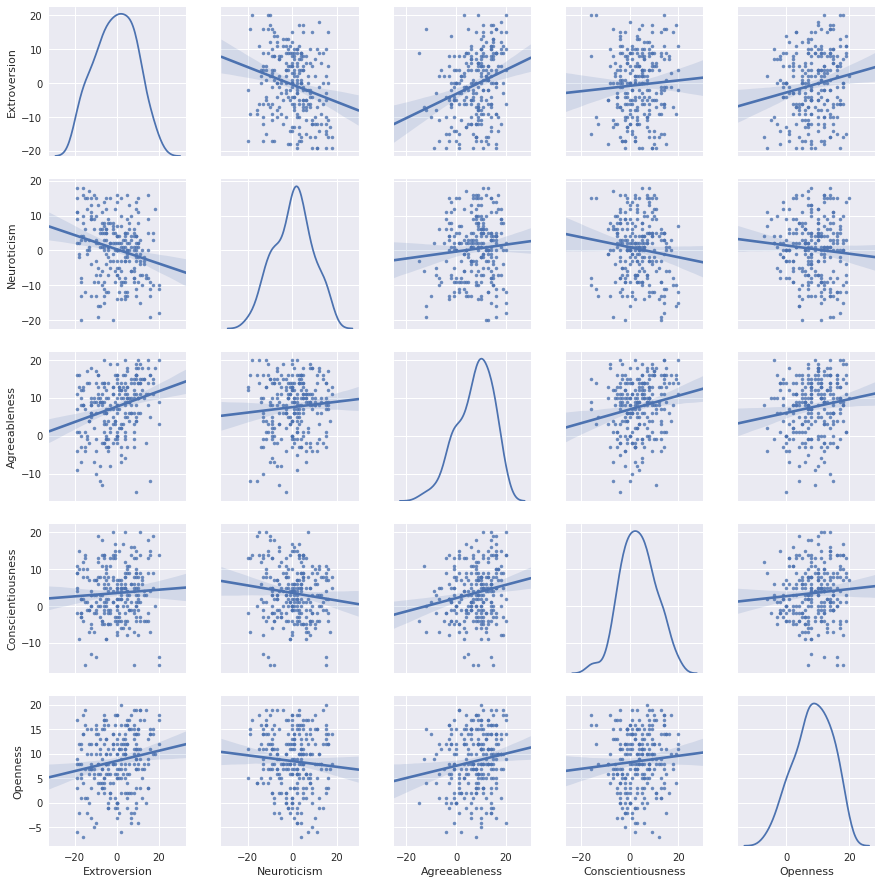

In [418]:
# Visually checking Multicollinearity using scatter plots
########################################### Referenced From kernel by Petar Luketina  #############################################
sns.pairplot(df_check[traits].rename(columns={k:v for k, v in zip(traits, trait_labels)}).sample(250), diag_kind="kde", kind="reg", markers=".");

In [419]:
##########Multocollinearity within the traits###### High computation takes a long time
####Run only if needed
#ext = ps.sqldf('select EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10 from df')
#ext.corr()
#est = ps.sqldf('select EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10 from df')
#est.corr()
#agr = ps.sqldf('select AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10 from df')
#agr.corr()
#csn = ps.sqldf('select CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10 from df')
#csn.corr()
#opn = ps.sqldf('select OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10 from df')
#opn.corr()

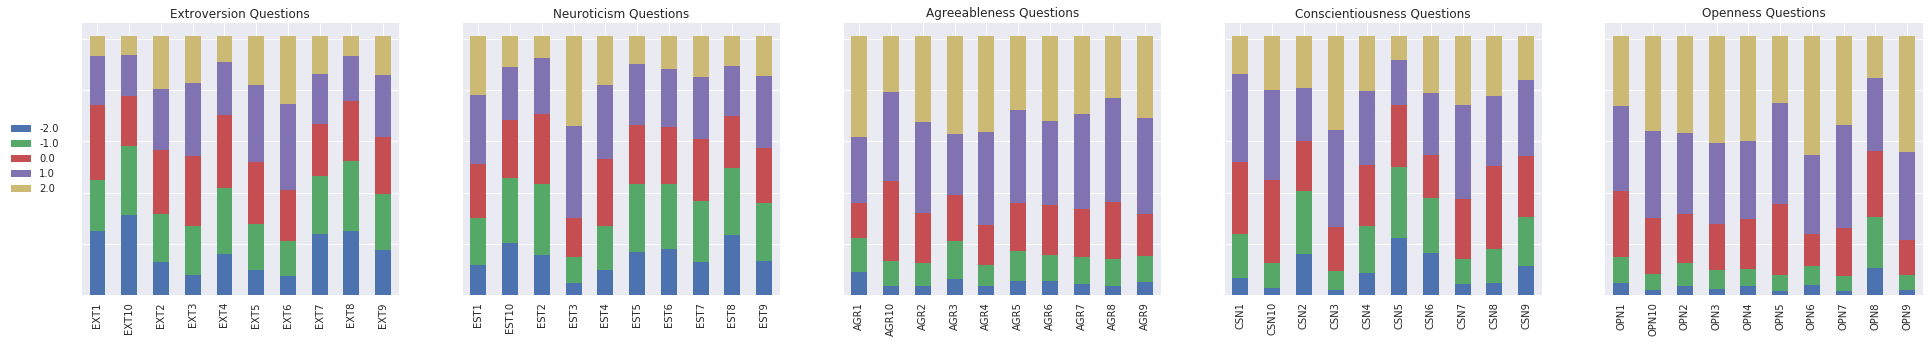

In [420]:
# Scores Distribution for every trait for every question
########################################### Referenced From kernel by Petar Luketina  #############################################
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(33,5))
for i, (trait, label) in enumerate(zip(traits, trait_labels)):
    trait_cols = sorted([col for col in cols if trait in col and '_E' not in col])
    g = df_check[trait_cols].apply(lambda col: col.value_counts()).T.plot(kind='bar', stacked=True, ax=axs[i])
    g.set(yticklabels=[], title = label + ' Questions')
    if not i:
        g.legend(loc='center left', bbox_to_anchor=(-.25, 0.5), ncol=1)
    else:
        g.legend_.remove()

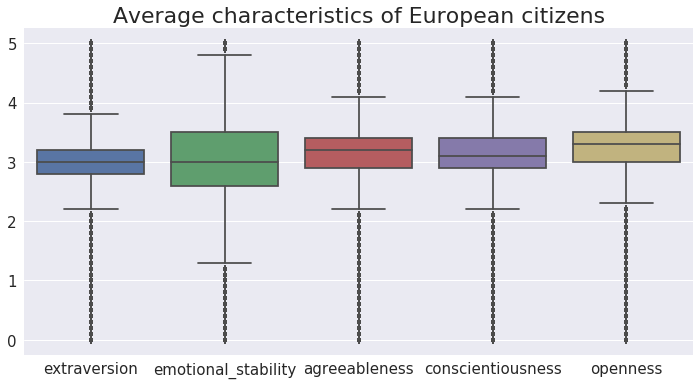

In [421]:
########################################### Referenced From kernel by Jakub Gajdul  #############################################

# Create an aggregated feature for each of the five personality dimensions.
# They will average the 10 answers across the dimension.

# Extraversion 
EXT = list(df.columns[:10])
# Emotional Stability
EST = list(df.columns[10:20])
# Agreeableness
AGR = list(df.columns[20:30])
# Conscientiousness
CSN = list(df.columns[30:40])
# Openness
OPN = list(df.columns[40:50])

dimensions = [EXT,EST,AGR,CSN,OPN]
dimension_averages=["extraversion","emotional_stability",
       "agreeableness","conscientiousness","openness"]
for d in range(len(dimensions)):
    df[dimension_averages[d]] = df[dimensions[d]].mean(axis=1)
    
#Use a boxlot to visualise the 5 variables
# This method will give us a good overview of the distribution across the variables
sns.set_style("darkgrid")

#reset default parameters
sns.set()
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.5)
sns.boxplot(data=df[dimension_averages]);
plt.title("Average characteristics of European citizens",fontsize=22)
plt.savefig('avg_char.png')
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 a

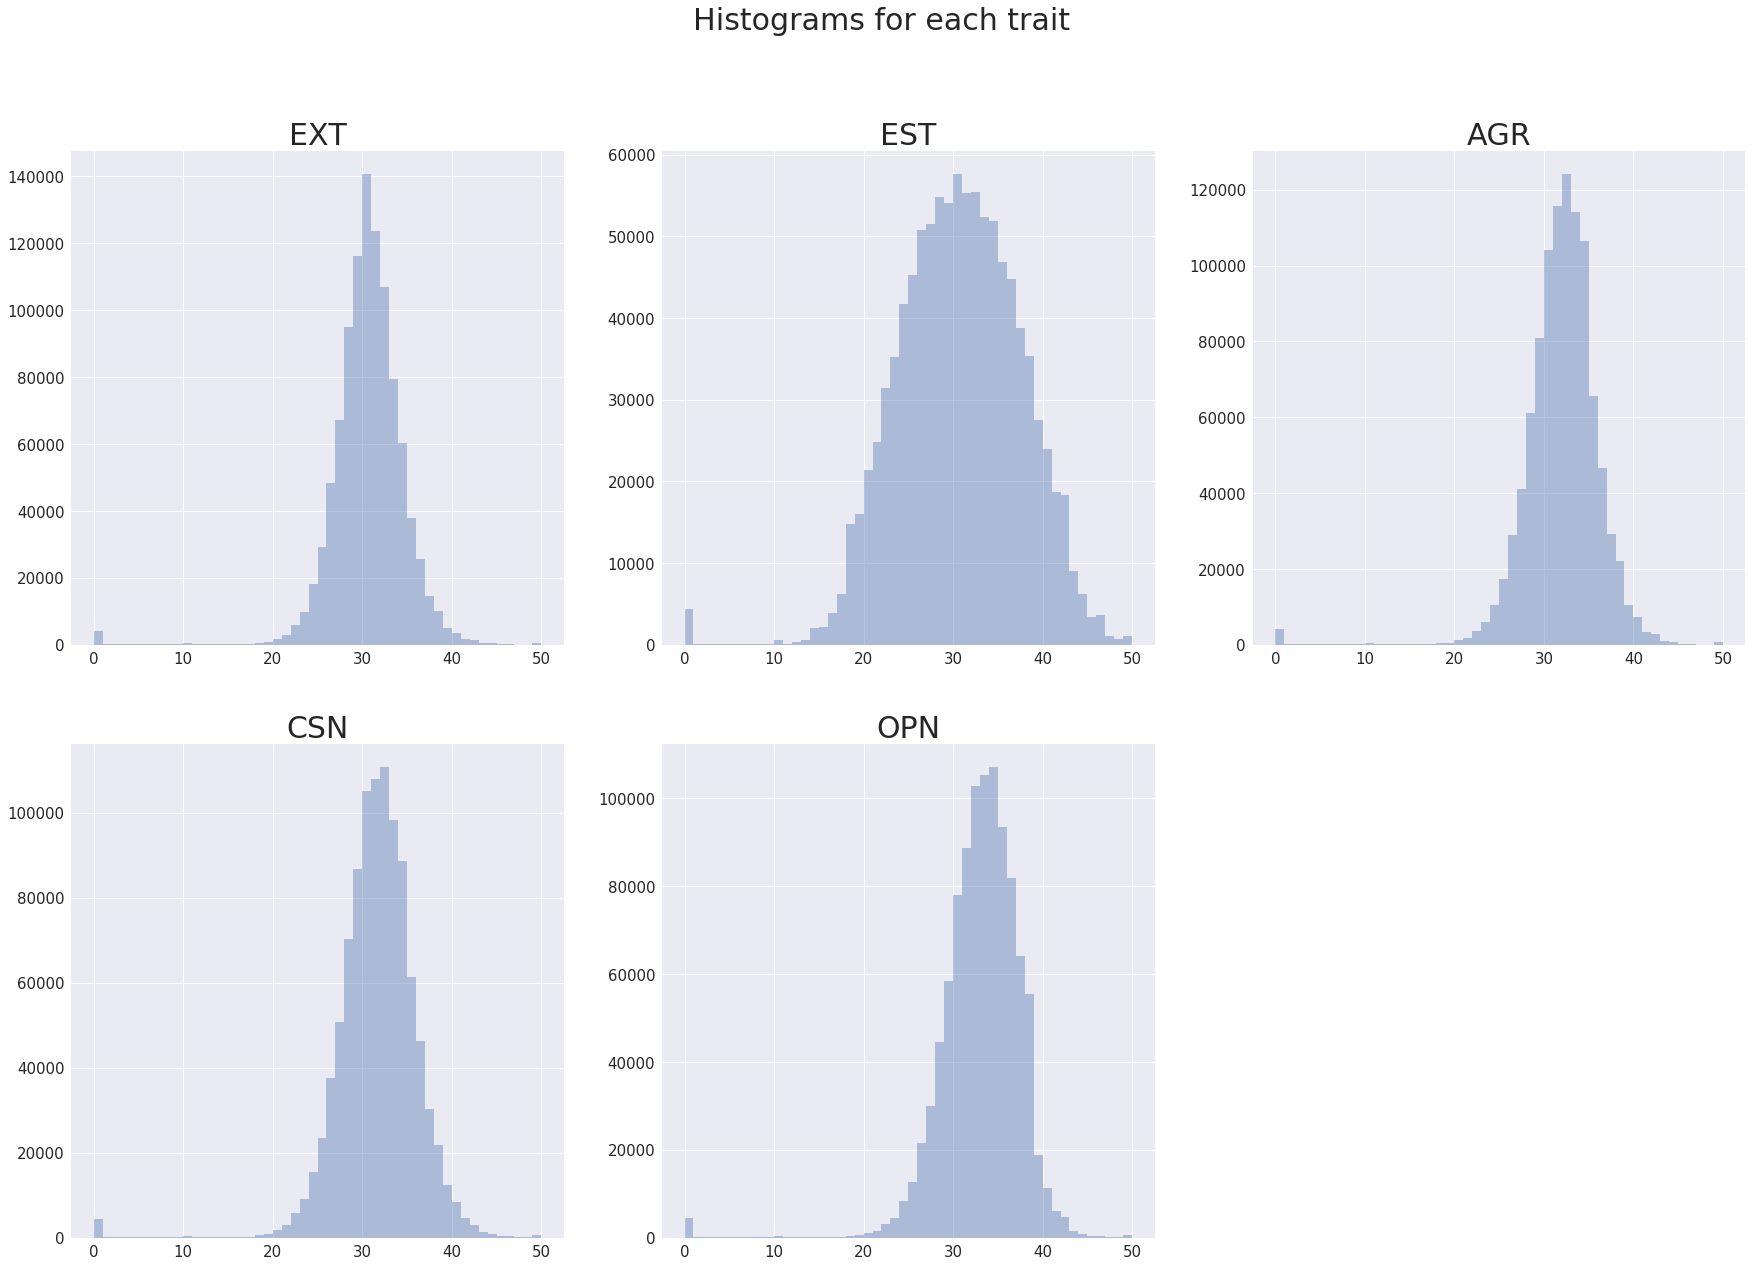

In [422]:
############################### Referenced From kernel by Jakub Gajdul  ###########################################
# Score Distribution --- Here average of scores is taken into account
negatives = [ 
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5
    'EST2','EST4',                       # 2
    'AGR1','AGR3','AGR5','AGR7',         # 4
    'CSN2','CSN4','CSN6','CSN8',         # 4
    'OPN2','OPN4','OPN6',                # 3
]
df_for_score = df.copy()
df_for_score[negatives] = df_for_score[negatives].replace({1:5, 2:4, 3:3, 4:2, 5:1})
a=range(1,11)
ext_cols = [('EXT'+str(i)) for i in a]
est_cols = [('EST'+str(i)) for i in a]
agr_cols = [('AGR'+str(i)) for i in a]
csn_cols = [('CSN'+str(i)) for i in a]
opn_cols = [('OPN'+str(i)) for i in a]

traits = [ext_cols, est_cols, agr_cols, csn_cols, opn_cols]
df_scores = pd.DataFrame(index = df.index)

# Sum scores to calculate scores for each trait
for trait in traits:
    df_scores = pd.concat([df_scores,(df.loc[:,trait]).sum(axis=1)], axis = 1)
    
df_scores.columns=['EXT', 'EST', 'AGR', 'CSN', 'OPN']
df_scores = pd.concat([df_scores, df.country], axis = 1)
df_scores.head()

#Histogram plots to show the distribution of averaged scores
hist_plots = plt.figure(figsize=(30,20))

for i in range(5):
    plt.subplot(2,3,i+1)
    plt.title(label=df_scores.columns[i],fontsize=30)
    sns.distplot(df_scores.iloc[:,i], axlabel=False, kde=False)

hist_plots.suptitle('Histograms for each trait', fontsize=30)
plt.show()



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 a

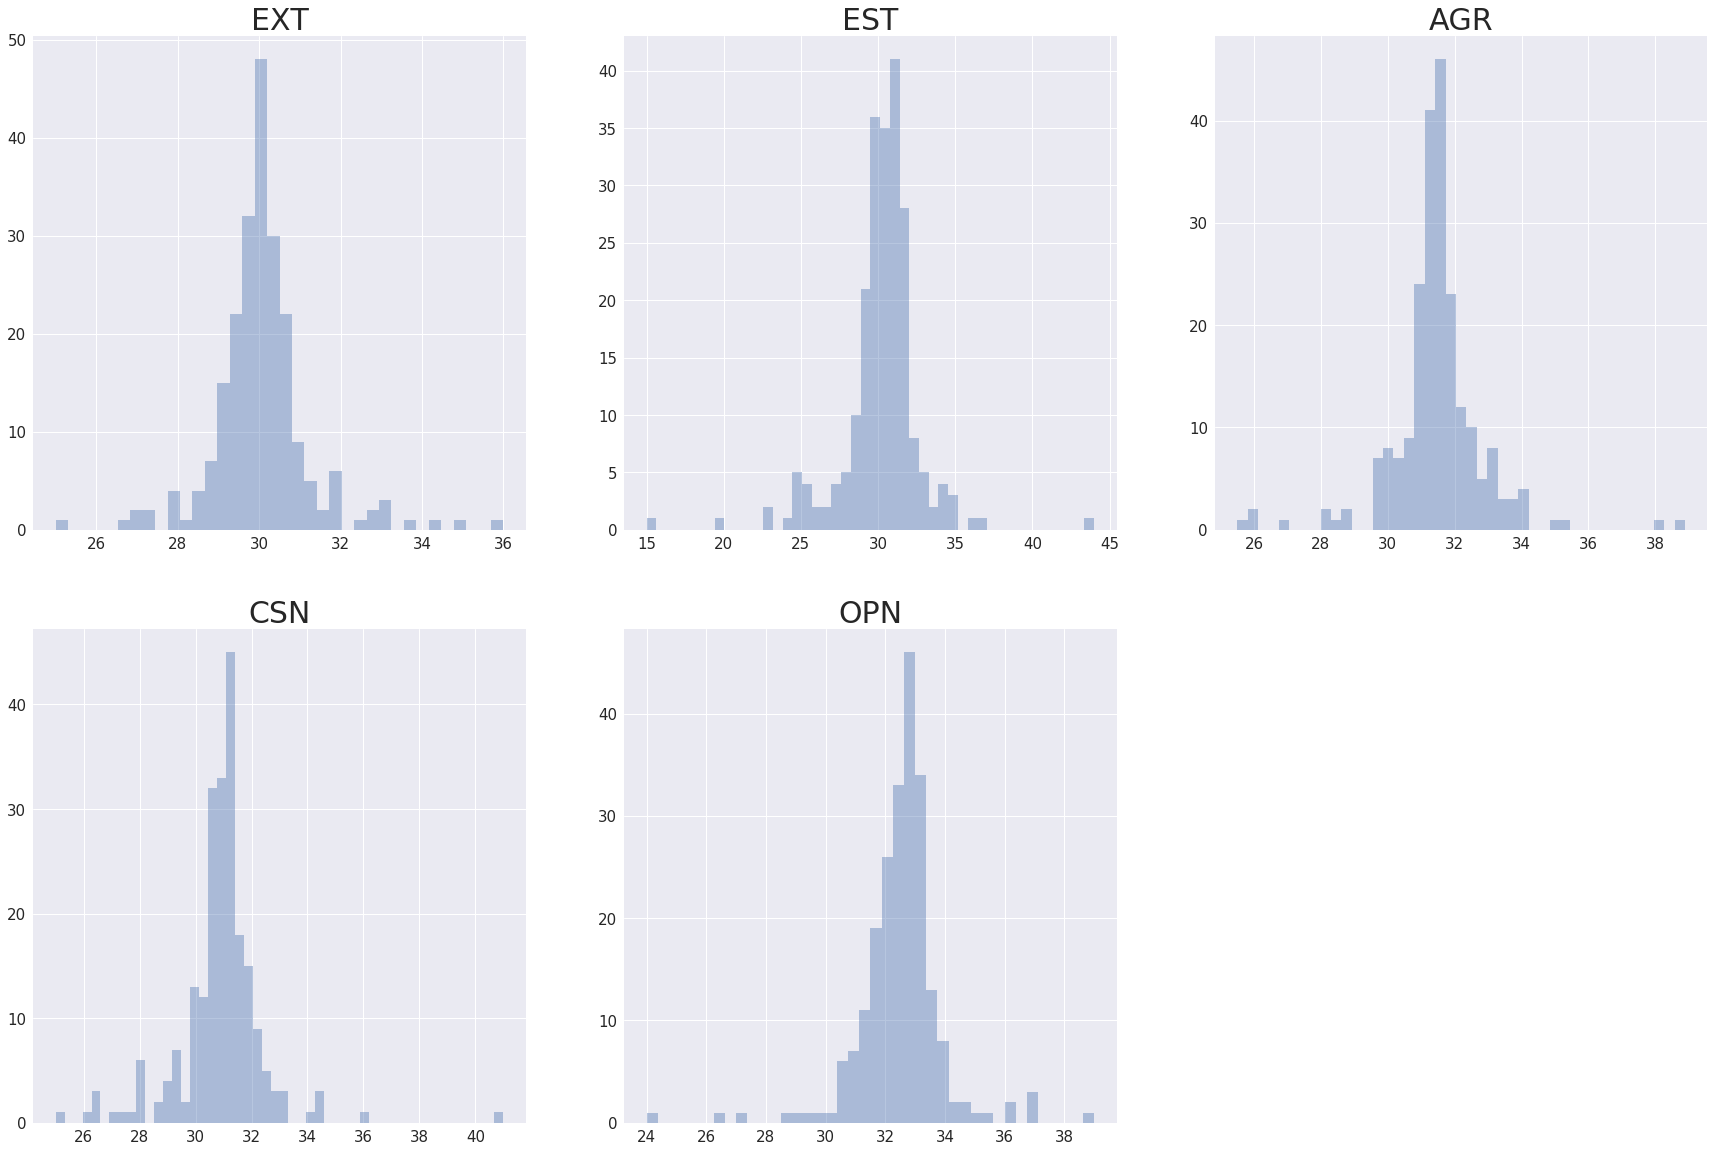

In [423]:
############################### Referenced From kernel by Jakub Gajdul  ###########################################

#Distribution of scores with respect to country --- Again of average is used as an aggregation operation
scores_by_country = df_scores.groupby('country').mean()
scores_by_country.head()
country_distplots = plt.figure(figsize=(30,20))
for i in range(5):
    plt.subplot(2,3,i+1)
    colname = scores_by_country.columns[i]
    plt.title(label=colname,fontsize=30)
    sns.distplot(scores_by_country.iloc[:,i], axlabel=False, kde=False)

plt.show()

EXT    18715
EST    15165
AGR    20582
CSN    19114
OPN    18258
dtype: int64


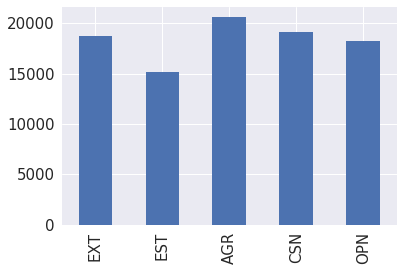

In [424]:
############################### Referenced From kernel by Jakub Gajdul  ###########################################

#Check the impact of outliers
import numpy as np
#count outliers in each trait
zscores = pd.DataFrame(index = df_scores.index)
for trait in list(df_scores.columns[0:5]):
    zscores[trait] = (df_scores[trait] - df_scores[trait].mean()) / df_scores[trait].std(ddof=0)
    
# zscores = pd.concat([zscores, df_scores.country], axis = 1)
is_neg_outlier = (zscores < -2)
count_outliers = is_neg_outlier.apply(np.count_nonzero)
count_outliers.columns=['Trait','Negative_Outliers']
print(count_outliers)
## Number of outliers per 
count_outliers.plot.bar(x='Trait', y='Negative_Outliers')

is_neg_outlier = pd.concat([is_neg_outlier, df_scores.country], axis = 1)

In [425]:
############################### Referenced From kernel by Jakub Gajdul  ###########################################

#Frequency of responses against country
!pip install geopandas
!pip install pycountry
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import geopandas as gpd
import pycountry

country_dict = {i.alpha_2: i.alpha_3 for i in pycountry.countries}
countries = pd.DataFrame(df.country.value_counts()).T\
              .drop('NONE', axis=1)\
              .rename(columns=country_dict, index={'country': 'count'})
countries

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


,USA,GBR,CAN,AUS,PHL,IND,DEU,NZL,NOR,MYS,...,BDI,FLK,MHL,GNQ,GIN,MAF,TCD,COM,SHN,NER
count,546403,66596,61849,50030,19847,17491,14095,12992,11417,11355,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
############################### Referenced From kernel by Arun Spiky  ###########################################

#Check influence of predictors
answer_data = df.iloc[:,0:50]
answer_data['country'] = df['country']
for col in answer_data.columns:
    answer_data[col] = answer_data[col].astype('category').cat.codes
corr_data = pd.DataFrame(answer_data.corr()['country'][:])
corr_data = corr_data.reset_index()
top_correlation = corr_data.sort_values('country', ascending=False)['index'].to_list()
top_correlation

In [427]:
#Remove duplicate responses
df = df.loc[df['IPC']==1]
len(df)

696845

In [428]:
#filter response columns
df = df.loc[(df[df.columns.tolist()[:49]] >= 1).all(axis=1)]
len(df)

604343

In [429]:
############################### Referenced From kernel by Jakub Gajdul  ###########################################

# positive questions adding to the trait.
pos_questions = [ 
    'EXT1','EXT3','EXT5','EXT7','EXT9',                       # 5
    'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10', # 8
    'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',               # 6
    'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',               # 6
    'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10',        # 7
]

# negative (negating) questions subtracting from the trait.
neg_questions = [ 
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5
    'EST2','EST4',                       # 2
    'AGR1','AGR3','AGR5','AGR7',         # 4
    'CSN2','CSN4','CSN6','CSN8',         # 4
    'OPN2','OPN4','OPN6',                # 3
]

df[pos_questions] = df[pos_questions].replace({1:-2, 2:-1, 3:0, 4:1, 5:2})
df[neg_questions] = df[neg_questions].replace({1:2, 2:1, 3:0, 4:-1, 5:-2})

In [430]:
#Remove and check for NAs
df = df.dropna()
df.isna().mean().sum()

0.0

In [431]:
# columns with time spent answering questions --- A check on the latency
qtime_cols = list(df.columns)[50:100]

In [432]:
# Calculate the total time for each survey
df['total_time']=df[qtime_cols].sum(axis=1)
df['total_time'].describe()

count    6.036610e+05
mean     4.771077e+05
std      7.805683e+06
min     -7.873258e+07
25%      1.668580e+05
50%      2.158510e+05
75%      2.960940e+05
max      2.147711e+09
Name: total_time, dtype: float64

In [433]:
# filter using latency
df = df[df['total_time'].between(10000,1000000)]

In [434]:
# List the redundant cols such as longitude and latitudee
drop_cols=list(df.columns[50:107])+['lat_appx_lots_of_err','long_appx_lots_of_err']

In [435]:
# Drop the redundant cols
df=df.drop((drop_cols), axis=1)

In [436]:
# A list of all EU countries, count them
EU = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]

In [437]:
#filter for EU countries
df = df.loc[df['country'].isin(EU)]

In [438]:
len(df)

110841

In [439]:
# Count responses by country
df['country'].value_counts()[:5]

GB    42598
DE    10575
NL     6700
SE     6344
FR     4390
Name: country, dtype: int64

In [440]:
#keep country seperately to use it later or concatenation
Main_df = ps.sqldf('select country from df')
Main_df = Main_df.iloc[1:len(Main_df)-1,:]

In [441]:
#PCA
from sklearn.decomposition import PCA
pca_ = PCA(n_components=2)

a = df.iloc[1:len(df)-1,0:10]
principalComponents_ = pca_.fit_transform(a)
Main_df = pd.concat([Main_df,pd.DataFrame(data=principalComponents_[:,:],columns = ['EXT1','EXT2'])],axis=1,ignore_index=True,sort=False)
pca_.explained_variance_

b = df.iloc[1:len(df)-1,10:20]
principalComponents_1 = pca_.fit_transform(b)
Main_df_1 = pd.concat([Main_df,pd.DataFrame(data=principalComponents_1[:,:],columns = ['EST1','EST2'])],axis=1, ignore_index=True,sort=False)
pca_.explained_variance_


c = df.iloc[1:len(df)-1,20:30]
principalComponents_ = pca_.fit_transform(c)
Main_df_2 = pd.concat([Main_df_1,pd.DataFrame(data=principalComponents_[:,:],columns = ['AGR1','AGR2'])],axis=1, ignore_index=True)
pca_.explained_variance_

d = df.iloc[1:len(df)-1,30:40]
principalComponents_ = pca_.fit_transform(d)
Main_df_3 = pd.concat([Main_df_2,pd.DataFrame(data=principalComponents_[:,:],columns = ['CSN1','CSN2'])], axis=1,ignore_index=True)
pca_.explained_variance_

e = df.iloc[1:len(df)-1,40:50]
principalComponents_ = pca_.fit_transform(e)
Main_df_4 = pd.concat([Main_df_3,pd.DataFrame(data=principalComponents_[:,:],columns = ['OPN1','OPN2'])],axis=1,ignore_index=True)
pca_.explained_variance_

#Play and check for the Eigen values >=1 ## can be used for every pca above
pca_.explained_variance_


array([3.71990505, 1.48390459])

In [442]:
#Rename the columns
Main_df_4.columns = ['country','EXT1','EXT2','EST1','EST2','AGR1','AGR2','CSN1','CSN2','OPN1','OPN2']

In [443]:
#Adjustments due to scaling issues
Main_df_4['country'][0]='GB'
Main_df_4 = Main_df_4.dropna()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [444]:
#Scalinf the Principal compponents
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data_pca = scaler.fit_transform(Main_df_4.iloc[:,1:11])

In [445]:

##########Finding value of k in clustering ##### I have USed this only at the start to find good value for k
#Sum_of_squared_distances = []
#K = range(1,20)
#from sklearn.cluster import KMeans
#for k in K:
#    km = KMeans(n_clusters=k)
#   km = km.fit(scaled_data_pca)
#    Sum_of_squared_distances.append(km.inertia_)
#plt.plot(K, Sum_of_squared_distances, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Sum_of_squared_distances')
#plt.title('Elbow Method For Optimal k')
#plt.show()

In [446]:
#Fix with 15 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15)
y = kmeans.fit_predict(scaled_data_pca)
scaled_data_pca_df = pd.DataFrame(data=scaled_data_pca[:,:])

In [447]:
############An attemp to use k-prototype clustering
#from kmodes.kprototypes import KPrototypes
#test=KPrototypes(n_clusters=5, init='Huang')
#cluster=test.fit_predict(scaled_data_pca, categorical=[0])


In [448]:
#Assigning the cluster labels to itmes
scaled_data_pca_df['Cluster'] = y

In [449]:
#Rename the header after clustering
scaled_data_pca_df.columns = ['EXT1','EXT2','EST1','EST2','AGR1','AGR2','CSN1','CSN2','OPN1','OPN2','cluster']

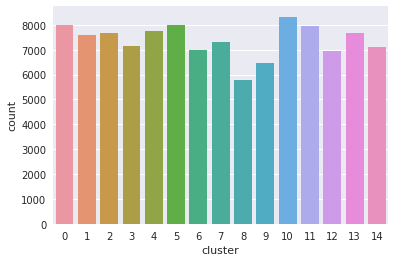

In [450]:
#check the cluster distribution
sns.countplot(x='cluster', data=scaled_data_pca_df)

In [451]:
#Adding country back to the data after clustering
country_df = ps.sqldf('select country from Main_df_4')
scaled_data_pca_df_cntry = pd.concat([country_df,scaled_data_pca_df],ignore_index=True,axis=1)
scaled_data_pca_df_cntry.columns = ['country','EXT1','EXT2','EST1','EST2','AGR1','AGR2','CSN1','CSN2','OPN1','OPN2','cluster']

In [452]:
#Subset df to only those with country GB, PL
gb = scaled_data_pca_df_cntry.loc[scaled_data_pca_df_cntry['country']=="GB"]
pl = scaled_data_pca_df_cntry.loc[scaled_data_pca_df_cntry['country']=="PL"]
#create the output label
scaled_data_pca_df_cntry['is_gb'] = scaled_data_pca_df_cntry['country'].apply(lambda x: 1 if x =='GB' else 0)

In [ ]:
############################### Referenced From kernel by Arun Spiky  ###########################################

#check infulence of predictors on output
answer_data = scaled_data_pca_df_cntry.copy()
for col in answer_data.columns:
    answer_data[col] = answer_data[col].astype('category').cat.codes
corr_data = pd.DataFrame(answer_data.corr()['country'][:])
corr_data = corr_data.reset_index()
top_correlation = corr_data.sort_values('country', ascending=False)['index'].to_list()
top_correlation

In [454]:
# Copy the dataframe
df_ml = scaled_data_pca_df_cntry.copy()

to_drop =["country"]
          #+["extraversion","emotional_stability","agreeableness","conscientiousness","openness"]
    
# Delete old column indicating country
df_ml = df_ml.drop(columns=to_drop)

# Shuffle the data to ensure that split is fair
df_ml = df_ml.sample(n=len(df_ml),random_state=42)

In [455]:
#Check for class imbalance
import pandasql as ps
ps.sqldf('select is_gb,count(*) from df_ml group by is_gb')

,is_gb,count(*)
0,0,68243
1,1,42596


In [456]:
#Upsampling of minor classes
from sklearn.utils import resample
#Separate majority and minority classes
df_majority = df_ml[df_ml['is_gb']==0]
df_minority = df_ml[df_ml['is_gb']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=68243,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.is_gb.value_counts()

1    68243
0    68243
Name: is_gb, dtype: int64

In [457]:
#Select the dependent variable
Y = df_upsampled['is_gb']
X = df_upsampled.drop('is_gb',axis=1)
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [458]:
#Decision Tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
decision_prediction = decision_tree.predict(X_test)
accuracy_score(y_test, decision_prediction)

0.7199794856766063

In [459]:
#Ensemble model
from sklearn.ensemble import RandomForestClassifier
#Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=5, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=5,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [460]:
#Training and testing
y_pred=clf.predict(X_test)
#After training, check the accuracy using actual and predicted values.

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix

#Evaluation # Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

Accuracy: 0.776613671331233
[[11072  2679]
 [ 3419 10128]]


In [461]:
#Continued evaluation of the model
TP = 11128  
FP = 2623
FN = 3392 
TN = 10155

Accuracy = (TP+TN)/(TP+FP+FN+TN)
print(Accuracy)

Precision = TP/(TP+FP)
print(Precision)

Recall = TP/(TP+FN)
print(Recall)

F1_Score = 2*(Recall * Precision) / (Recall + Precision)
print(F1_Score)

Specificity = TN/(TN+FP)
print(Specificity)

Error_rate = 1-Accuracy
print(Error_rate)






0.7796541871199355
0.8092502363464475
0.7663911845730027
0.7872378055250964
0.7947253091250587
0.2203458128800645


0.7763986021897429


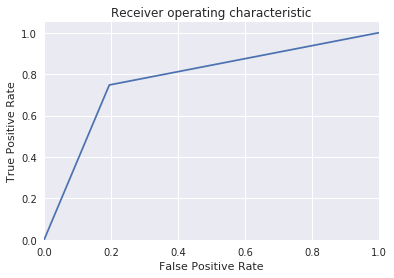

In [462]:
#ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_auc_score(y_test, y_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [463]:
#K-fold cross validation
from sklearn.model_selection import KFold
scores = []
clf = RandomForestClassifier(n_jobs=5, random_state=0)
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Train Index:  [ 13649  13650  13651 ... 136483 136484 136485] 

Test Index:  [    0     1     2 ... 13646 13647 13648]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [13649 13650 13651 ... 27295 27296 27297]
Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [27298 27299 27300 ... 40944 40945 40946]
Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [40947 40948 40949 ... 54593 54594 54595]
Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [54596 54597 54598 ... 68242 68243 68244]
Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [68245 68246 68247 ... 81891 81892 81893]
Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [81894 81895 81896 ... 95539 95540 95541]
Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [ 95542  95543  95544 ... 109187 109188 109189]
Train Index:  [     0      1      2 ... 136483 136484 136485] 

Test Index:  [109190 109191 109192 ... 122835 122836 122837]
Train Index:  [     0      1      2 

In [464]:
#List of scores
print(scores)
np.mean(np.asarray(scores))

[0.7550736317678951, 0.7546340391237454, 0.7596160890907758, 0.7641585464136567, 0.756465675141036, 0.7263535790167778, 0.729337631887456, 0.7291910902696366, 0.7423798358733881, 0.7288247362250879]


0.7446034854809456

In [465]:
#Distribution of scores
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scores_= np.asarray(scores)
scaled_accuracy = scaler.fit_transform(pd.DataFrame(data=scores_[:]))

In [466]:
print(scaled_accuracy)

[[ 0.7373549 ]
 [ 0.70639681]
 [ 1.05725522]
 [ 1.37715554]
 [ 0.83538887]
 [-1.28524068]
 [-1.07509023]
 [-1.08541035]
 [-0.15659943]
 [-1.11121065]]
